In [24]:
from pylab import rcParams
import pandas as pd
from utilsforecast.plotting import plot_series
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor': '#212946',

    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,

    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.linewidth': '1',
    'grid.color': '#2A3459',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12}
plt.rcParams.update(dark_style)


rcParams['figure.figsize'] = (8, 4)

In [25]:
df = pd.read_excel('../../Data/IDA & DA Ierland 2023.xlsx')
da = pd.DataFrame({
    'ds': df['Datetime'],
    'unique_id': 1,
    'y': df['IE DA EUR']
})
ida1 = pd.DataFrame({
    'ds': df['Datetime'],
    'unique_id': 1,
    'y': df['IE IDA1 EUR price']
})
ida2 = pd.DataFrame({
    'ds': df['Datetime'],
    'unique_id': 1,
    'y': df['IE IDA2 EUR price']
})

SAMPLE DAY:  2023-11-04


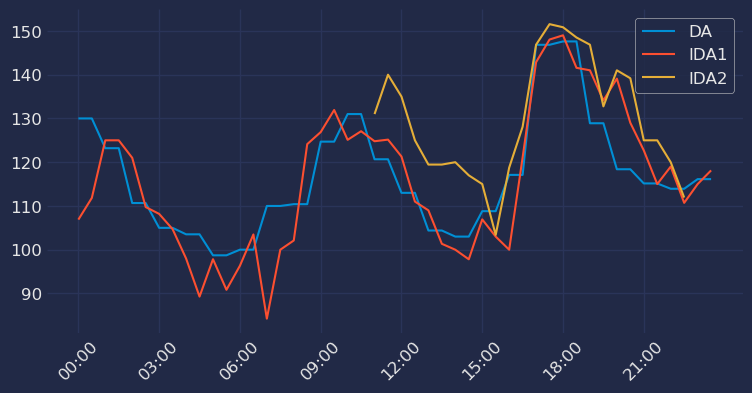

In [3]:
random_state = 1
sample_day = df.sample(n=1, random_state=random_state)
print("SAMPLE DAY: ", sample_day['Datetime'].dt.date.values[0])
sample_da = da[da['ds'].dt.date == sample_day['Datetime'].dt.date.values[0]]
sample_ida1 = ida1[ida1['ds'].dt.date ==
                   sample_day['Datetime'].dt.date.values[0]]
sample_ida2 = ida2[ida2['ds'].dt.date ==
                   sample_day['Datetime'].dt.date.values[0]]
plt.plot(sample_da['ds'], sample_da['y'], label='DA')
plt.plot(sample_ida1['ds'], sample_ida1['y'], label='IDA1')
plt.plot(sample_ida2['ds'], sample_ida2['y'], label='IDA2')

plt.xticks(sample_da['ds'][::6], sample_da['ds'].dt.strftime(
    '%H:%M')[::6], rotation=45)
plt.legend()
plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Correlation: 0.9339517969580933


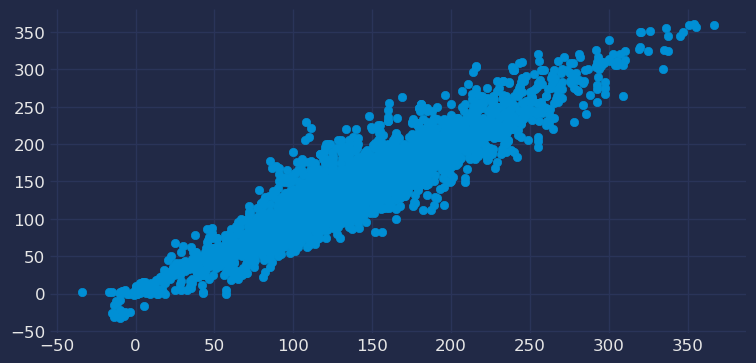

In [4]:
from scipy.stats import pearsonr

ida_combined = ida1.merge(ida2, on='ds', suffixes=('_ida1', '_ida2'))
ida_combined.dropna(inplace=True)
plt.scatter(ida_combined['y_ida1'], ida_combined['y_ida2'])
corr, _ = pearsonr(ida_combined['y_ida1'], ida_combined['y_ida2'])
print("Correlation:", corr)

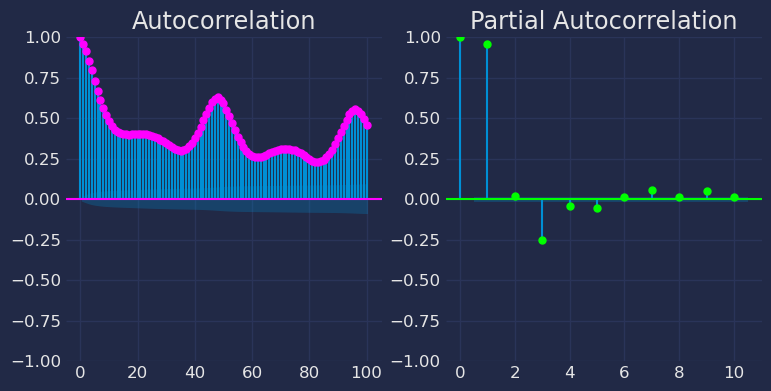

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(ida1["y"],  lags=100, ax=axs[0], color="fuchsia")
axs[0].set_title("Autocorrelation")

plot_pacf(ida1["y"],  lags=10, ax=axs[1], color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show()

In [36]:
train_ida1, test_ida1 = ida1[ida1['ds'].dt.month <
                             12], ida1[ida1['ds'].dt.month >= 12]
train_ida2, test_ida2 = ida2[ida2['ds'].dt.month <
                             12], ida2[ida2['ds'].dt.month >= 12]
train_da,   test_da = da[da['ds'].dt.month <
                         12],     da[da['ds'].dt.month >= 12]

## MSTL


In [37]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA


def create_MSTL(seasons):
    models = [
        MSTL(season_length=seasons,
             trend_forecaster=AutoARIMA(seasonal=True)
             )
    ]

    sf = StatsForecast(
        models=models,
        freq='30min',
    )

    return sf

In [38]:
train_ida2 = train_ida2.merge(
    train_da[['ds', 'y']], on='ds', suffixes=('', '_DA')).dropna()
train_ida2.reset_index(drop=True, inplace=True)

In [39]:
train_ida2

,ds,unique_id,y,y_DA
0,2023-01-01 11:00:00,1,168.40,189.92
1,2023-01-01 11:30:00,1,193.72,189.92
2,2023-01-01 12:00:00,1,172.72,198.40
3,2023-01-01 12:30:00,1,197.18,198.40
4,2023-01-01 13:00:00,1,204.73,201.87
...,...,...,...,...
8011,2023-11-30 20:30:00,1,124.09,154.64
8012,2023-11-30 21:00:00,1,132.74,137.61
8013,2023-11-30 21:30:00,1,118.34,137.61
8014,2023-11-30 22:00:00,1,109.06,125.00


In [40]:
tp = 24
model = create_MSTL([tp, tp*2])
cross_val = model.cross_validation(df=train_ida2,
                                   h=tp,
                                   step_size=tp,
                                   n_windows=30)

/Users/tijnschutte/opt/anaconda3/envs/scriptie/lib/python3.11/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [41]:
cross_val['error'] = cross_val['y'] - cross_val['MSTL']

In [42]:
cross_val.to_excel('../../Data/Crossvalidation/cross_val_30_days_ida2.xlsx')

In [ ]:
len(train_ida2.loc[train_ida2['ds'].dt.date ==
    train_ida2['ds'].dt.date.values[0]].dropna())

24

In [ ]:
da_model = create_MSTL([48, 2*48, 5*48, 6*48])
da_prediction = da_model.forecast(df=train_da, h=48)
da_prediction = da_prediction.merge(test_da.head(48), on='ds')

In [ ]:
da_prediction.plot('ds', ['y', 'MSTL'])
mae = abs(da_prediction['y']-da_prediction['MSTL']).mean()
# da_prediction.to_excel('../Data/DA_forecast.xlsx')
print('MAE:', str(round(mae, 2)))

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA

half_hourly = 1
hourly = half_hourly*2
daily = hourly*24
weekly = daily*7
monthly = daily*30


def give_me_mstl(seasons=[]):
    models = [
        MSTL(
            season_length=seasons,
            trend_forecaster=AutoARIMA(
                seasonal=True)
        )
    ]

    return StatsForecast(
        models=models,
        freq='30min',
    )

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
days = 10
decomposition = seasonal_decompose(
    train_ida2['y'].dropna().head(48*days), model='additive', period=48)
fig, axes = plt.subplots(4, 1, sharex=True)
train_ida2['y'].dropna().head(48*days).plot(ax=axes[0])
decomposition.trend.plot(ax=axes[1])
decomposition.seasonal.plot(ax=axes[2])
decomposition.resid.plot(ax=axes[3])

In [ ]:
trading_length = 48
da_mstl = give_me_mstl(
    seasons=[trading_length, 2*trading_length, 7*trading_length])
da_prediction = da_mstl.forecast(df=train_da, h=trading_length)
da_prediction = da_prediction.merge(test_da.head(trading_length), on='ds')

In [ ]:
da_prediction.plot('ds', ['y', 'MSTL'])
mae = abs(da_prediction['y']-da_prediction['MSTL']).mean()
print('MAE:', str(round(mae, 2)))

In [ ]:
tp = 48
ida1_mstl = give_me_mstl(seasons=[tp, tp*2, tp*4, tp*6, tp*8])
ida1_prediction = ida1_mstl.forecast(df=train_ida1, h=tp)
ida1_prediction = ida1_prediction.merge(test_ida1.head(tp), on='ds')
ida1_prediction.plot('ds', ['y', 'MSTL'])
mae = abs(ida1_prediction['y']-ida1_prediction['MSTL']).mean()
print('MAE:', str(round(mae, 2)))

In [ ]:
tp_id2 = 24
test_ida2_copy = test_ida2.dropna().head(tp_id2)
ida2_mstl = give_me_mstl(
    seasons=[tp_id2, tp_id2*2, tp_id2*3, tp_id2*4, tp_id2*5, tp_id2*6])
ida2_prediction = ida2_mstl.forecast(df=train_ida2.dropna(), h=tp_id2)
ida2_prediction['ds'] = test_ida2_copy['ds'].values
ida2_prediction = ida2_prediction.merge(test_ida2_copy, on='ds')
print("MAE:", abs(ida2_prediction['y']-ida2_prediction['MSTL']).mean())
ida2_prediction.plot('ds', ['y', 'MSTL'])

In [ ]:
train_exo = train_ida1.merge(train_da, on='ds', suffixes=(
    '', '_da')).drop(columns='unique_id_da')
test_exo = test_ida1.merge(test_da, on='ds', suffixes=(
    '', '_da')).drop(columns='unique_id_da')

In [ ]:
date = '2023-12-09'
weird = pd.read_excel(f'../Data/Forecasts/DA/{date}_exo[].xlsx')
date_mask = test_da['ds'].dt.date == weird['ds'].dt.date.values[0]
real = test_da.loc[date_mask]
# print(real)
plt.plot(real['ds'], real['y'], label='True')
plt.plot(weird['ds'], weird['MSTL'], label='DA')

### PAST ERRORS


In [ ]:
# crossvalidation_df = sf.cross_validation(df=train_da,
#                                          h=48,
#                                          step_size=48,
#                                          n_windows=30)

In [ ]:
# crossvalidation_df['error'] = crossvalidation_df['y'] - \
#     crossvalidation_df['MSTL']
# crossvalidation_df.to_excel('../Data/cross_val_30_days_da.xlsx')
crossvalidation_df = pd.read_excel(
    '../Data/Crossvalidation/cross_val_30_days_ida1.xlsx')
crossvalidation_df.head()

In [ ]:
error_distr = crossvalidation_df.groupby(
    [crossvalidation_df['ds'].dt.hour, crossvalidation_df['ds'].dt.minute])['error'].describe()

In [ ]:
# TODO peak variance to determine scenario shifts
peaks_y = crossvalidation_df.groupby(crossvalidation_df['ds'].dt.day)[
    'y'].apply(list).apply(lambda row: np.argmax(row))
peaks_mstl = crossvalidation_df.groupby(crossvalidation_df['ds'].dt.day)[
    'MSTL'].apply(list).apply(lambda row: np.argmax(row))
peaks_errors = peaks_y - peaks_mstl
peaks_errors.mean()

In [ ]:
error_distr.head(2)

In [ ]:
# TODO sample errors per percentile (per half-hour? per day?)

errors_high = error_distr.apply(lambda row: np.percentile(np.random.normal(
    row['mean'], row['std'], 10000), 90), axis=1)
errors_middle = error_distr.apply(lambda row: np.percentile(np.random.normal(
    row['mean'], row['std'], 10000), 50), axis=1)
errors_low = error_distr.apply(lambda row: np.percentile(np.random.normal(
    row['mean'], row['std'], 10000), 10), axis=1)

scenarios = np.vstack(
    [errors_high, errors_middle, errors_low]) + ida1_prediction['MSTL'].values
scenarios_df = pd.DataFrame(scenarios).T
scenarios_df.columns = ['S_high', 'S_med', 'S_low']
scenarios_df['y'] = ida1_prediction['y'].values
scenarios_df['MSTL'] = ida1_prediction['MSTL'].values
# scenarios_df.to_excel('../Data/scenarios.xlsx', index=False)
plt.plot(pd.DataFrame(scenarios).T.set_index(ida1_prediction['ds']))
plt.plot(ida1_prediction['ds'], ida1_prediction['y'], label='True')

In [ ]:
def generate_scenarios(predictions):
    errors_high = error_distr.apply(lambda row: np.percentile(np.random.normal(
        row['mean'], row['std'], 10000), 90), axis=1)
    errors_middle = error_distr.apply(lambda row: np.percentile(np.random.normal(
        row['mean'], row['std'], 10000), 50), axis=1)
    errors_low = error_distr.apply(lambda row: np.percentile(np.random.normal(
        row['mean'], row['std'], 10000), 10), axis=1)

    scenarios = np.vstack(
        [errors_high, errors_middle, errors_low]) + predictions
    scenarios_df = pd.DataFrame(scenarios).T
    scenarios_df.columns = ['high', 'middle', 'low']
    return scenarios_df

In [ ]:
scenarios = crossvalidation_df.groupby(crossvalidation_df['ds'].dt.day)[
    'MSTL'].apply(list).apply(lambda row: generate_scenarios(row))

In [ ]:
scenarios = pd.concat(scenarios.values)

In [ ]:
window = 6*48
plt.plot(crossvalidation_df['ds'].tail(window), scenarios.tail(window))
plt.plot(crossvalidation_df['ds'].tail(window),
         crossvalidation_df['y'].tail(window), label='True')
plt.plot(crossvalidation_df['ds'].tail(
    window), crossvalidation_df['MSTL'].tail(window), label='MSTL')
plt.legend()

In [ ]:
# crossvalidation_ida2 = pd.read_excel('../Data/Crossvalidation/cross_val_30_days_ida2.xlsx')

In [ ]:
# num_simulations = 20
# mean_error, std_error = stats.norm.fit(crossvalidation_df['error'])

high = 90
med = 50
low = 10

error_distr_per_halfhour = crossvalidation_df.groupby(
    [crossvalidation_df['ds'].dt.hour, crossvalidation_df['ds'].dt.minute])['error'].describe()

high_error = error_distr_per_halfhour.apply(lambda row: np.percentile(np.random.normal(
    row['mean'], row['std'], 10000), high), axis=1).values
medium_error = error_distr_per_halfhour.apply(lambda row: np.percentile(np.random.normal(
    row['mean'], row['std'], 10000), med), axis=1).values
low_error = error_distr_per_halfhour.apply(lambda row: np.percentile(np.random.normal(
    row['mean'], row['std'], 10000), low), axis=1).values

high_noise = np.full((1, 48), high_error)
med_noise = np.full((1, 48), medium_error)
low_noise = np.full((1, 48), low_error)

# Combine scenarios
simulated_scenarios = np.vstack([
    high_noise, med_noise, low_noise,
]) + prediction_exo['MSTL'].values

# Create shifted versions of the scenarios
shifted_scenarios = []
for i in range(len(simulated_scenarios)):
    shifted_scenarios.append(np.roll(simulated_scenarios[i], shift=-10))

simulated_scenarios = np.vstack([simulated_scenarios, *shifted_scenarios])
scenarios = pd.DataFrame(simulated_scenarios).T


def rolling(list):
    return list.rolling(3).mean().fillna(method='bfill')


# scenarios = scenarios.apply(rolling, axis=0)

scenarios.columns = [f"S_{i}" for i in range(len(scenarios.columns))]
scenarios['y'] = prediction_exo['y'].values
scenarios['MSTL'] = prediction_exo['MSTL'].values
# scenarios.to_excel('../Data/scenarios.xlsx', index=False)

plt.plot(scenarios)
plt.plot(prediction_exo['y'], label='True')
plt.xlabel('Half-Hour Step')
plt.ylabel('Price')
plt.title('Simulated Price Scenarios')
plt.show()

#### Error distribution per half hour


In [ ]:
from scipy.stats import norm

errors_grouped = crossvalidation_df.groupby(
    [crossvalidation_df['ds'].dt.hour, crossvalidation_df['ds'].dt.minute])['error'].apply(list)

for errors in errors_grouped:
    mean, std = norm.fit(errors)
    x = np.linspace(min(errors), max(errors), 100)
    pdf = norm.pdf(x, mean, std)
    plt.plot(x, pdf)

#### Split errors into segments, for each segment create a scenario (with weight)

##### Doesn't allow for shifting, because then what would be the weight of that scenario?


In [ ]:
# SPINNING WHEEL method (TODO)

error_segments = [
    (-3*std, -std),  # Large negative error
    (-std, 0),       # Small negative error
    (0, std),        # Zero error
    (std, 3*std)     # Small positive error, Large positive error can be combined
]

# Calculate weights based on historical error frequencies
weights = []
for segment in error_segments:
    lower, upper = segment
    error_counts = errors_grouped.apply(lambda errors: sum(
        [lower <= error <= upper for error in errors]))
    weight = error_counts.sum() / len(errors_grouped.sum())
    weights.append(weight)

print(weights)

In [ ]:
simulated_scenarios = []
    for segment in error_segments:
        lower, upper = segment
        med = 50
        medium_error = np.percentile(np.random.uniform(
            lower, upper, 10000), med)
        med_noise = np.full((1, 48), medium_error)
        scenarios = med_noise + ida1_prediction['MSTL'].values
        simulated_scenarios.append(scenarios)

simulated_scenarios = np.vstack(simulated_scenarios)
scenarios = pd.DataFrame(simulated_scenarios).T
scenarios['y'] = ida1_prediction['y'].values

plt.plot(scenarios)
plt.plot(ida1_prediction['y'], label='True')
plt.legend()

In [ ]:
# Generate scenarios for each error segment
scenarios = []
for _ in range(4):
    for lower, upper in error_segments:
        segment_errors = np.random.uniform(
            lower, upper, len(ida1_prediction['MSTL']))
        scenario = ida1_prediction['MSTL'] + segment_errors
        scenarios.append(scenario)

# Convert scenarios to DataFrame
scenarios_df = pd.DataFrame(scenarios).T
scenarios_df.columns = [f'Scenario_{i}' for i in range(len(scenarios))]
scenarios_df['ds'] = ida1_prediction['ds']
scenarios_df['y'] = ida1_prediction['y']

# Plot the scenarios
for col in scenarios_df.columns[:-2]:
    plt.plot(scenarios_df['ds'], scenarios_df[col], label=col)
plt.plot(scenarios_df['ds'], scenarios_df['y'],
         label='True', color='black', linewidth=2)
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.title('Price Scenarios for Each Error Segment')
plt.show()
print(weights)

## CI using price distribution


In [ ]:
prediction1 = prediction_exo.copy()

In [ ]:
high, middle, low = 0.9, 0.5, 0.1
train_distr = train_ida1.groupby([train_ida1['ds'].dt.dayofweek, train_ida1['ds'].dt.hour, train_ida1['ds'].dt.minute])[
    'y'].describe(percentiles=[low, middle, high])
train_distr.head(4)

In [ ]:
# BEGIN: Add confidence interval to cross_val based on historical price distribution
confidence_level = 0.95
z_score = 1.96

# Calculate the mean and standard deviation of the historical MSTL values
historical_mean = train_distr['mean']
historical_std = train_distr['std']

# Map the historical mean and std to the cross_val DataFrame
prediction1['historical_mean'] = prediction1['ds'].apply(lambda x: historical_mean.loc[(x.dayofweek, x.hour, x.minute)])
prediction1['historical_std'] = prediction1['ds'].apply(lambda x: historical_std.loc[(x.dayofweek, x.hour, x.minute)])

# Calculate the confidence intervals
prediction1['ci_lower'] = prediction1['MSTL'] - z_score * prediction1['historical_std'] / np.sqrt(len(prediction1))
prediction1['ci_upper'] = prediction1['MSTL'] + z_score * prediction1['historical_std'] / np.sqrt(len(prediction1))

prediction1[['ds', 'y', 'MSTL', 'ci_lower', 'ci_upper']].head(5)

In [ ]:
prediction1[['ds', 'y', 'ci_lower', 'ci_upper']].plot(x='ds', figsize=(10, 6), title='MSTL with 95% confidence interval')
coverage = ((prediction1['y'] >= prediction1['ci_lower']) & (prediction1['y'] <= prediction1['ci_upper'])).mean()
print(f'Coverage: {coverage:.2f}')

## CI - Multi Step Forecasting


In [ ]:
ida1_prediction_copy = ida1_prediction.copy()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(train_ida1['y'], lags=200)
plt.title('Autocorrelation Function (ACF) of Errors')
plt.show()

In [ ]:
def create_ci_95(forecast, train):
    forecast = forecast.copy()
    z_score = 1.96
    rolling_window = 50  # Adjust the window size as needed
    se = train['y'].rolling(window=rolling_window).std(
    ).iloc[-1] / np.sqrt(len(forecast))
    forecast['h'] = forecast.groupby(
        forecast['ds'].dt.date).cumcount() + 1 + 12
    forecast['SE_h'] = se * np.sqrt(forecast['h'])
    forecast['CI-lo'] = forecast['MSTL'] - z_score * forecast['SE_h']
    forecast['CI-hi'] = forecast['MSTL'] + z_score * forecast['SE_h']
    forecast.drop(columns=['h'], inplace=True)
    if 'y' in forecast.columns:
        print('Coverage:', round(sum([1 for y, lo, hi in zip(
            forecast['y'], forecast['CI-lo'], forecast['CI-hi']) if lo <= y <= hi]) / len(forecast), 2))
    return forecast


prediction_with_ci = create_ci_95(ida1_prediction_copy, train_ida1)
prediction_with_ci[-48*3:].plot('ds', ['y', 'CI-hi', 'CI-lo', 'MSTL'])
plt.show()

In [ ]:
plt.plot(prediction_with_ci['ds'],
         prediction_with_ci['CI-hi'] - prediction_with_ci['CI-lo'])
plt.xticks(rotation=45)
plt.show()

In [ ]:
def monte_carlo(df, N=1):
    df = df.copy()
    '''Generates three scenarios-high, middle and low- based on the CI'''
    scenario_high = np.random.uniform(df['MSTL'], df['CI-hi'], len(df))
    scenario_low = np.random.uniform(df['CI-lo'], df['MSTL'], len(df))
    # scenario_high = pd.Series(scenario_high).rolling(window=2).mean().values
    # scenario_low = pd.Series(scenario_low).rolling(window=2).mean().values
    df['S_high'] = scenario_high
    df['S_low'] = scenario_low

    for n in range(N):
        scenario_middle = np.random.uniform(df['CI-lo'], df['CI-hi'], len(df))
        scenario_middle = pd.Series(
            scenario_middle).rolling(window=2).mean().values
        df[f'S_middle_{n}'] = scenario_middle
    return df


cv_scenarios = monte_carlo(prediction_with_ci, 10)
cv_scenarios.plot('ds', [*cv_scenarios.filter(like='S').columns], legend=False)
cv_scenarios.plot('ds', 'y', legend=True)
plt.legend()
plt.show()

In [ ]:
# UIT DE DATA SCENARIOS SAMPLEN - ZONDER CI
grouped_train_ida1 = train_ida1.groupby(
    [train_ida1['ds'].dt.hour, train_ida1['ds'].dt.minute])['y'].describe()
grouped_train_ida1.head(4)

#### Test on predicted day


In [ ]:
prediction_exo_ci = create_ci_95(prediction_exo, train_exo)
prediction_exo_scenarios = monte_carlo(prediction_exo_ci, 3)
prediction_exo_scenarios.drop(
    columns=['unique_id']).plot('ds')

In [ ]:
prediction_exo_scenarios.columns

In [ ]:
prediction_exo_scenarios['SE_h'].values

In [ ]:
# prediction_exo_scenarios.fillna(method='bfill', inplace=True)
# prediction_exo_scenarios.drop(columns=['unique_id']).to_excel(
#     'ida_predictions.xlsx', index=False)

### DA


In [ ]:
day = 48
da_mstl = create_MSTL(seasons=[day, day*2, day*5, day*6])
da_mstl.fit(train_da)
da_mstl.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

In [ ]:
predictions_da = da_mstl.predict(h=day)
plt.plot(test_da['ds'].head(day), test_da['y'].head(day))
plt.plot(predictions_da['ds'], predictions_da['MSTL'])
mae = np.mean(
    np.abs(predictions_da['MSTL'].values - test_da['y'].head(day).values))
print("MAE:", mae)
plt.show()

In [ ]:
predictions_da = predictions_da.merge(test_da[['ds', 'y']].head(day), on='ds')
da_std_erros = train_da['y'].std() / np.sqrt(len(predictions_da))
predictions_da['h'] = predictions_da.groupby(
    predictions_da['ds'].dt.date).cumcount() + 1
predictions_da['SE_h'] = da_std_erros * np.sqrt(predictions_da['h'])
print(predictions_da.columns)
# predictions_da.to_excel('../Data/da_prediction.xlsx', index=False)

In [ ]:
train_ida2_filtered = train_ida2.copy()
train_ida2_filtered.dropna(inplace=True)
train_ida2_filtered.reset_index(drop=True, inplace=True)
train_ida2_filtered

In [ ]:
trading_length = len(train_ida2_filtered.groupby(
    train_ida2_filtered.ds.dt.hour)) * 2

In [ ]:
model_ida2 = create_MSTL(
    seasons=[trading_length, 2*trading_length, 5*trading_length, 6*trading_length])
forecast_ida2 = model_ida2.forecast(df=train_ida2_filtered, h=trading_length)
forecast_ida2.reset_index(drop=True, inplace=True)
forecast_ida2['ds'] = test_ida2.dropna().head(
    trading_length)['ds'].reset_index(drop=True)

In [ ]:
# crossvalidation_df = model_ida2.cross_validation(
#     df=train_ida2_filtered, h=48, step_size=48, n_windows=30)

In [ ]:
# nan_mask = train_ida2.groupby('ds')['y'].apply(lambda x: x.isna().all())
# valid_times = nan_mask[nan_mask == False].index
# crossvalidation_df = crossvalidation_df[crossvalidation_df['ds'].isin(
#     valid_times)]
# crossvalidation_df['error'] = crossvalidation_df['y'] - \
#     crossvalidation_df['MSTL']
# crossvalidation_df.to_excel('../Data/cross_val_30_days_ida2.xlsx', index=False)

In [ ]:
import numpy as np
import pandas as pd


def create_scenarios_with_trend(cross_val, predictions, block_size=6, num_scenarios=3):
    # Group the cross_val by time of day to capture the error trends over time
    cross_val['hour'] = cross_val['ds'].dt.hour
    cross_val['minute'] = cross_val['ds'].dt.minute

    # Group errors by time of day (hour and minute) and get mean/std for each period
    error_trends = cross_val.groupby([cross_val['hour'], cross_val['minute']])[
        'error'].agg(['mean', 'std']).reset_index()

    scenarios = []

    # Ensure that predictions DataFrame has a datetime 'ds' column
    for _ in range(num_scenarios):
        sampled_errors = []

        # Sample blocks of errors for each time of day, respecting the upward trend
        for i in range(len(predictions) // block_size):
            # Get the corresponding datetime (ds) for the current block
            # Ensure 'ds' is a datetime column
            timestamp = predictions['ds'].iloc[i * block_size]
            hour = timestamp.hour
            minute = timestamp.minute

            # Find the corresponding mean and std for the current block's time
            error_info = error_trends[(error_trends['hour'] == hour) & (
                error_trends['minute'] == minute)]
            if not error_info.empty:
                mean = error_info['mean'].values[0]
                std = error_info['std'].values[0]

                # Sample errors for the block based on the time-specific mean and std
                block_errors = np.random.normal(mean, std, block_size)
                sampled_errors.append(block_errors)

        # Flatten the sampled errors into a single array
        sampled_errors = np.hstack(sampled_errors)[:len(predictions)]

        # Apply a rolling mean to smooth the scenario
        scenario = predictions['MSTL'].values + sampled_errors
        scenario = pd.Series(scenario).rolling(
            window=3).mean().fillna(method='bfill').values

        scenarios.append(scenario)

    return np.array(scenarios)


# Example usage
scenarios = create_scenarios_with_trend(crossvalidation_df, ida1_prediction)
plt.plot(scenarios.T)
plt.plot(ida1_prediction['y'], label='True')
plt.legend()
plt.show()

## GROUP BY BLOCKS PER DAY AND SAMPLE BLOCKS


In [ ]:
def split_and_group_errors_by_block(cross_val, block_size=3):
    cross_val['ds'] = pd.to_datetime(cross_val['ds'])
    cross_val['date'] = cross_val['ds'].dt.date

    blocks_by_day = []
    grouped = cross_val.groupby('date')

    for _, group in grouped:
        errors = group['error'].values
        num_blocks = len(errors) // block_size
        blocks = [errors[i * block_size:(i + 1) * block_size]
                  for i in range(num_blocks)]
        blocks_by_day.append(blocks)

    # Now group corresponding blocks across days together
    grouped_blocks = list(zip(*blocks_by_day))

    return grouped_blocks


# Set block size and apply the function
block_size = 6
grouped_blocks = split_and_group_errors_by_block(
    crossvalidation_df, block_size)

In [ ]:
import random

num_scenarios = 1
scenarios = []
for i in range(num_scenarios):
    scenario = []
    for block_index, block in enumerate(grouped_blocks):
        correlated_block = random.choice(block)
        ida1_prediction_block = ida1_prediction['MSTL'].values[block_index * block_size:(
            block_index + 1) * block_size]
        scenario.extend(ida1_prediction_block + correlated_block)
    scenarios.append(scenario)

scenarios = np.array(scenarios)
plt.plot(scenarios.T)
plt.plot(ida1_prediction['y'])
plt.show()

In [ ]:
def generate_scenarios(cross_val, ida1_prediction, block_size=6, num_scenarios=1):
    cross_val['ds'] = pd.to_datetime(cross_val['ds'])
    cross_val['date'] = cross_val['ds'].dt.date
    blocks_by_day = [
        group['error'].values.reshape(-1, block_size) for _, group in cross_val.groupby('date')]
    grouped_blocks = list(zip(*blocks_by_day))

    scenarios = []
    for _ in range(num_scenarios):
        scenario = []
        for block_index, block in enumerate(grouped_blocks):
            correlated_block = random.choice(block)
            ida1_prediction_block = ida1_prediction[block_index *
                                                    block_size:(block_index + 1) * block_size]
            scenario.extend(ida1_prediction_block + correlated_block)
        scenarios.append(scenario)

    scenarios = np.array(scenarios)
    return scenarios


generate_scenarios(crossvalidation_df, ida1_prediction['MSTL'].values)

In [ ]:
sample_date = pd.to_datetime("2023-3-10").date()
sample_da = da[da['ds'].dt.date == sample_date]
sample_ida1 = ida1[ida1['ds'].dt.date ==
                   sample_date]
sample_ida2 = ida2[ida2['ds'].dt.date ==
                   sample_date]
df = sample_da.merge(sample_ida1, on='ds', suffixes=('_1', '_2')).rename(
    {'y_1': 'Auction 1', 'y_2': 'Auction 2'}, axis=1)

df['hour'] = df['ds'].dt.strftime('%H:%M')
# df.plot('hour', ['Auction 1', 'Auction 2'])
df.plot('hour', ['Auction 1'])
plt.ylim(df[['Auction 1', 'Auction 2']].min().min(),
         df[['Auction 1', 'Auction 2']].max().max())
plt.xlabel('Delivery Time')
plt.xticks([i for i in range(0, len(df) + 1, 8)],
           list(df['hour'][::8]) + ['00:00'])
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.show()